In [1]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

## Import preprocessed data

In [2]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [3]:
df.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_status_Widow,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376


In [4]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x_education_2nd Cycle', 'x_education_Graduation', 'x_education_Master',
       'x_education_PhD', 'x_status_Married', 'x_status_Single',
       'x_status_Together', 'x_status_Widow', 'x_gender_M', 'x_dependents_1.0',
       'x_description_Kind of OK', 'x_description_Meh...',
       'x_description_OK nice!', 'x_description_Take my money!!', 'PC0', 'PC1',
       'PC2'],
      dtype='object')

In [5]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

In [6]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

# Density Based Clustering
## Mean Shift Clustering
What is Mean-shift clustering? How does it work?

Single seed             |  Multiple seeds
:-------------------------:|:-------------------------:
![](../figures/mean_shift_0.gif)  |  ![](../figures/mean_shift_tutorial.gif)
 
### Characteristics:
- No need to define number of clusters apriori
- Can detect clusters of any shape
- Robust to outliers
- Depends on the bandwidth hyperparameter (but there's a way to estimate it)
- **Main drawback**: Poor scalability (on both the algorithm and in estimating the bandwidth)

In [9]:
# The following bandwidth can be automatically detected using (we need to set quantile though)
# Based on distance to nearest neighbors for all observations
bandwidth = estimate_bandwidth(df[metric_features], random_state=1, n_jobs=-1, quantile=.05)
# TO-DO: manipulate the quantile value such that we obtain a small enough bandwidth
bandwidth

2.2293096708819555

In [11]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
# TO-DO: explore the MeanShift class and obtain the cluster labels
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms_labels = ms.fit_predict(df[metric_features])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 7


In [13]:
ms_labels.shape

(8817,)

In [14]:
from collections import Counter
Counter(ms_labels)

Counter({0: 7014, 5: 428, 6: 356, 3: 264, 1: 630, 2: 100, 4: 25})

In [15]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,ms_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,5
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0


In [16]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2686


## DBSCAN (Density-based spatial clustering of applications with noise)
What is DBSCAN clustering? How does it work?

DBSCAN animation            |  Core, border and noise
:-------------------------:|:-------------------------:
![](../figures/dbscan.gif)  |  ![](../figures/dbscan.jpg)


### Characteristics:
- No need to define number of clusters apriori
- Resistant to noise and outliers
- Can identify outliers
- Can handle clusters of different shapes and sizes
- Depends highly on the epsilon hyperparameter and it can be hard to tune
- Does not work well with clusters of varying densities

In [17]:
# Perform DBSCAN clustering
# TO-DO: explore the DBSCAN class and obtain the cluster labels
dbscan = DBSCAN(eps=1.5, min_samples=5, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [18]:
Counter(dbscan_labels)

Counter({0: 8575, -1: 242})

### Defining eps and min_samples:
- **MinPts**: As a rule of thumb, **minPts = 2 x dim** can be used, but it may be necessary to choose larger values for very large data, for noisy data or for data that contains many duplicates.

- **ε**: The value for ε can then be chosen by using a **k-distance graph**, plotting the distance to the kth (k = minPts - 1) nearest neighbor ordered from the largest to the smallest value. Good values of ε are where this plot shows an **"elbow"**: if ε is chosen much too small, a large part of the data will not be clustered; whereas for a too high value of ε, clusters will merge and the majority of objects will be in the same cluster. **The assumption is that for points in a cluster, their k nearest neighbors are at roughly the same distance**. Noise points have their k-th nearest neighbors at farther distance

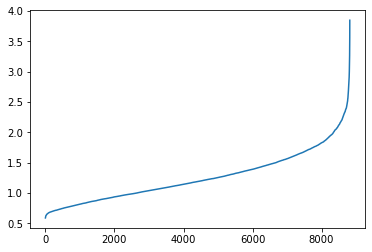

In [19]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df[metric_features])
distances, _ = neigh.kneighbors(df[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [21]:
# Perform DBSCAN clustering
# TO-DO: Re-cluster the data using the defined hyperparameters
dbscan = DBSCAN(eps=2, min_samples=2*len(metric_features), n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [23]:
Counter(dbscan_labels)

Counter({0: 8764, -1: 53})

In [24]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,dbscan_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0


In [25]:
# Detecting noise (potential outliers)
df_concat[df_concat["dbscan_labels"]== -1]

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,dbscan_labels
18,0.705467,-0.640275,-0.273146,-1.704776,-0.379855,-1.165068,3.976684,3.877621,-1.473995,-0.707594,-1
77,-0.409958,0.733635,1.255236,-1.226165,-0.653437,1.852024,2.381296,-0.897173,1.339671,2.022158,-1
186,1.063291,-0.457087,1.521041,-1.313185,0.988052,-0.926877,1.221014,3.479722,0.095165,-0.175941,-1
320,1.505864,1.466387,-0.771532,-1.922327,3.997449,1.852024,-0.374374,-0.631907,-1.365777,0.681456,-1
1006,0.315197,-1.006651,1.454590,-0.965104,-0.379855,-0.212302,-0.519409,4.010255,-1.636322,-0.902293,-1
1275,-1.487430,0.275665,0.491045,-1.617756,-0.927018,1.375641,0.205767,3.347089,1.393780,0.926520,-1
1338,2.203601,1.741168,1.421364,-1.574246,2.355960,-0.371096,1.656119,1.622857,-0.878797,1.810671,-1
1697,1.395092,0.550447,-1.303143,-1.661266,2.492751,-1.085671,2.961437,1.755490,-1.744540,-0.381317,-1
1811,1.722416,3.298266,-0.937660,1.079873,-0.927018,-0.768082,-0.954515,-0.234007,0.744472,7.343381,-1
2268,0.169924,1.191605,-0.339598,-1.791796,3.723868,-0.450494,-0.084304,2.816556,0.203383,2.241001,-1


In [26]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat[df_concat["dbscan_labels"] != -1] 
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.0186


- Why did the DBSCAN gave us just one cluster?
- What can we do with the noisy data?

## GMM (Gaussian Mixture Model )
What is GMM? How does it work?
![](../figures/gmm.gif)

--- 

$$\mathcal{p(\vec{x})} \ = \ \sum_{i=1}^K \phi_i \mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \tag{eq1}$$
$$\mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \ = \ \frac{1}{\sqrt{{(2\pi)}^{K}|\Sigma_i|}}e^{-\frac{1}{2} (\vec{x} - \vec{\mu_i})^T \Sigma_i^{-1} (\vec{x} - \vec{\mu_i})} \tag{eq2}$$
$$\sum_{i=1}^K \phi_i \ = \ 1 \tag{eq3}$$

, where:
- $\phi_i$ is the component weight (scalar) for Component $i$ (probability of an observation being generated by Component $i$)
- $\vec{\mu_i}$ is the mean vector for Component $i$,
- $\Sigma_i$ is the Covariance matrix for Component $i$

---

- **(eq1)** gives the probability of a point $x$ given the estimated Gaussian mixture
- **(eq2)** is the probability density function of a multivariate Gaussian with mean $\vec{\mu_i}$ and covariance $\Sigma_i$
- **(eq3)** states that the sum of the component weights is 1, such that the total probability distribution normalizes to 1

### Characteristics:
- Assumes the data is generated from a mixture of finite number of Gaussian distributions with unknown parameters
- Use the EM (Expectation Maximization algorithm) to estimate the parameters
- Provides a probability of each observation belonging to each cluster
- Advantages over K-Means:
    - Can deal with spherical and elipsoid cluster shapes
    - Number of components needs to be defined apriori
    
[Read More](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)

In [29]:
# Performing GMM clustering
# TO-DO: explore the GaussianMixture class and obtain the cluster labels and the cluster probabilities
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=20, init_params='kmeans', random_state=42)
gmm_labels = gmm.fit_predict(df[metric_features])
labels_proba = gmm.predict_proba(df[metric_features])
labels_proba

array([[1.00000000e+00, 1.73649359e-10, 1.46398505e-32],
       [1.00000000e+00, 5.38729796e-15, 6.89581588e-81],
       [1.54492975e-16, 1.06233788e-55, 1.00000000e+00],
       ...,
       [9.02789283e-25, 1.29360323e-01, 8.70639677e-01],
       [9.99999987e-01, 4.73526833e-09, 8.08559561e-09],
       [3.21193514e-03, 9.96788065e-01, 8.56369922e-99]])

In [33]:
labels_proba.sum(1)

array([1., 1., 1., ..., 1., 1., 1.])

**Let's look at the estimated parameters:**

In [30]:
# The estimated component weights
gmm.weights_

array([0.33716671, 0.35268008, 0.31015321])

In [31]:
# The estimated mean vectors of the Components
gmm.means_

array([[ 0.97770385,  0.94446005, -0.05863409, -0.26816694,  0.10971717,
         0.32349141,  0.11300222,  0.06890421, -1.08450556,  0.48965623],
       [-0.06535864, -0.13046614, -0.01034405,  0.94076604, -0.64337401,
        -0.62201509, -0.6456256 , -0.61795103,  0.44578347,  0.22708907],
       [-0.98853886, -0.87836486,  0.07550334, -0.77823626,  0.61231743,
         0.35563648,  0.61130658,  0.62777621,  0.67205567, -0.79053049]])

In [32]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape

(3, 10, 10)

### Defining covariance_type:
This hyperparameter controls the **degrees of freedom** in the shape of each cluster The more degrees of freedom we have the more complex shapes the model can fit and the more computationally expensive the model will be.

![](../figures/gmm_covariance.png)

- `covariance_type="tied"` makes all components share the same general covariance matrix

### Defining n_components:

**AIC**: estimates the relative amount of information lost by a model used to represent the data-generation process. The smaller the better.

**BIC**: similar to AIC but penalizes more complex models (i.e. favors simpler models). The smaller the better.

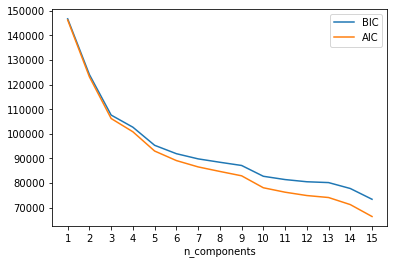

In [34]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[metric_features])
          for n in n_components]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df[metric_features]) for gmm in models]
aic_values = [gmm.aic(df[metric_features]) for gmm in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

**Note**: the AIC and BIC measures can also be used to select diferent hyperparameters such as the covariance_type

In [36]:
# Performing GMM clustering
# TO-DO: Re-cluster the data using the defined hyperparameters
gmm = GaussianMixture(n_components=5, covariance_type='full', n_init=50, init_params='kmeans', random_state=42)
gmm_labels = gmm.fit_predict(df[metric_features])

In [37]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,gmm_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,3
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,3
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,2
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,4


In [38]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.4359


# Clustering by Perspectives
- Demographic Perspective:
- Value Perspective:
- Product Perspective:

## Merging the Perspectives
- How can we merge different cluster solutions?